In [1]:
!pip install --upgrade paddlenlp -i https://pypi.org/simple

Requirement already up-to-date: paddlenlp in /opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages (2.0.6)


In [2]:
import json
import math
import os
import random
import time
from functools import partial

import numpy as np
import paddle
import paddlenlp

from paddle.io import DataLoader
from paddle.io import BatchSampler

from paddlenlp.data import Dict
from paddlenlp.data import Pad
from paddlenlp.data import Stack
from paddlenlp.data import Tuple

from paddlenlp.datasets import load_dataset
from paddlenlp.transformers import BertForSequenceClassification, BertTokenizer
from paddlenlp.transformers import ErnieForSequenceClassification, ErnieTokenizer
from paddlenlp.transformers import ErnieGramForSequenceClassification, ErnieGramTokenizer
from paddlenlp.transformers import RobertaForSequenceClassification, RobertaTokenizer
from paddlenlp.transformers import LinearDecayWithWarmup

# from utils import conver_example
from config import Config

Min:    6
Max:    204
Mean:    26.71953
25th percentile:    19.0
Median:             24.0
75th percentile:    31.0
95th percentile:    48.0
99th percentile:    67.0
99.9th percentile:    67.0


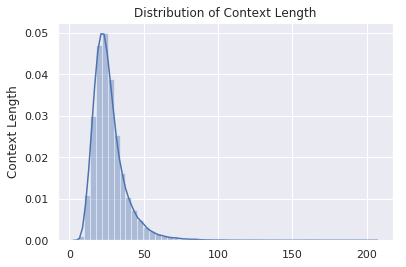

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from paddlenlp.datasets import load_dataset

train_ds =  load_dataset('bq_corpus', splits=['train'])
# train_ds =  load_dataset('paws-x', splits=['train'])
# train_ds =  load_dataset('lcqmc', splits=['train'])
input_length = []
for idx, example in enumerate(train_ds):
    input_length.append(
        len(example['sentence2']) + len(example['sentence1']) + 3
    )

input_length_array = np.array(input_length)

print("Min:   ", np.min(input_length_array))
print("Max:   ", np.max(input_length_array))
print("Mean:   ", np.mean(input_length_array))
print("25th percentile:   ", np.percentile(input_length_array, 25))
print("Median:            ", np.median(input_length_array))
print("75th percentile:   ", np.percentile(input_length_array, 75))
print("95th percentile:   ", np.percentile(input_length_array, 95))
print("99th percentile:   ", np.percentile(input_length_array, 99))
print("99.9th percentile:   ", np.percentile(input_length_array, 99))

sns.set(color_codes=True)
ax = sns.distplot(input_length)
ax.set_title('Distribution of Context Length')
ax.set_ylabel('Context Length')
plt.savefig('context_length.png')
plt.show()

In [4]:
from paddlenlp.datasets import load_dataset

train_ds =  load_dataset('bq_corpus', splits=['train'])
# train_ds =  load_dataset('paws-x', splits=['train'])
# train_ds =  load_dataset('lcqmc', splits=['train'])

for idx, example in enumerate(train_ds):
    len1 = len(example['sentence1'])
    len2 = len(example['sentence2'])
    if len1 >= 128:
        print(len1, len2) 


```
# sentence1 length

Min:    1
Max:    113
Mean:    11.61198
25th percentile:    7.0
Median:             10.0
75th percentile:    14.0
95th percentile:    24.0
99th percentile:    38.0
99.9th percentile:    38.0
```

```
# sentence2 length

Min:    1
Max:    153
Mean:    12.10755
25th percentile:    7.0
Median:             10.0
75th percentile:    14.0
95th percentile:    26.0
99th percentile:    39.0
99.9th percentile:    39.0
```

```
# sentence1 + sentence1 length
Min:    3
Max:    201
Mean:    23.71953
25th percentile:    16.0
Median:             21.0
75th percentile:    28.0
95th percentile:    45.0
99th percentile:    64.0
99.9th percentile:    64.0
```

In [5]:
MODEL_CLASSES = {
    "bert": (BertForSequenceClassification, BertTokenizer),
    "ernie": (ErnieForSequenceClassification, ErnieTokenizer),
    'ernie-gram': (ErnieGramForSequenceClassification, ErnieGramTokenizer),
    'roberta': (RobertaForSequenceClassification, RobertaTokenizer)
}

In [6]:
def set_seed(args):
    random.seed(args.seed)
    np.random.seed(args.seed)
    paddle.seed(args.seed)

In [7]:
def convert_example(example, tokenizer, max_seq_len=512, is_test=False):

    query, title = example['sentence1'], example['sentence2']

    encoded_inputs = tokenizer(text=query, text_pair=title, max_seq_len=max_seq_len)

    input_ids = encoded_inputs['input_ids']
    token_type_ids = encoded_inputs['token_type_ids']

    if not is_test:
        label = np.array([example['label']], dtype='int64')
        return input_ids, token_type_ids, label
    else:
        return input_ids, token_type_ids

In [8]:
@paddle.no_grad()
def evaluate(model, criterion, metric, data_loader):
    model.eval()
    metric.reset()
    
    losses = []

    for batch in data_loader:
        input_ids, token_type_ids, labels = batch
        probs = model(input_ids=input_ids, token_type_ids=token_type_ids)

        loss = criterion(probs, labels)
        losses.append(loss.numpy())

        correct = metric.compute(probs, labels)
        metric.update(correct)
        accu = metric.accumulate()
    
    model.train()
    metric.reset()

    return np.mean(losses), accu

In [9]:
def do_train(args):
    paddle.set_device(args.device)
    set_seed(args)

    args.model_type = args.model_type.lower()
    model_class, tokenizer_class = MODEL_CLASSES[args.model_type]
    tokenizer = tokenizer_class.from_pretrained(args.model_name_or_path)

    train_ds, dev_ds = load_dataset('bq_corpus', splits=['train', 'dev'], lazy=False)
    # train_ds, dev_ds = load_dataset('paws-x', splits=['train', 'dev'], lazy=False)
    # train_ds, dev_ds = load_dataset('lcqmc', splits=['train', 'dev'], lazy=False)

    trans_fn = partial(
        convert_example, 
        tokenizer=tokenizer, 
        max_seq_len=args.max_seq_len
    )
    train_ds.map(trans_fn)
    dev_ds.map(trans_fn)

    train_batch_sampler = BatchSampler(
        dataset=train_ds, 
        batch_size=args.batch_size, 
        shuffle=True
    )
    dev_batch_sampler = BatchSampler(
        dataset=dev_ds,
        batch_size=args.batch_size,
        shuffle=False
    )

    batchify_fn = lambda samples, fn=Tuple(
        Pad(axis=0, pad_val=tokenizer.pad_token_id),
        Pad(axis=0, pad_val=tokenizer.pad_token_type_id),
        Stack(dtype='int64')
    ): [data for data in fn(samples)]

    train_data_loader = DataLoader(
        dataset=train_ds,
        batch_sampler=train_batch_sampler,
        collate_fn=batchify_fn,
        return_list=True
    )
    dev_data_loader = DataLoader(
        dataset=dev_ds,
        batch_sampler=dev_batch_sampler,
        collate_fn=batchify_fn,
        return_list=True
    )

    save_dir = os.path.join(args.save_dir, 'best_model')
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # model = model_class.from_pretrained(args.model_name_or_path)
    model = model_class.from_pretrained(save_dir)

    num_training_steps = args.max_steps if args.max_steps > 0 else len(
        train_data_loader) * args.num_train_epochs
    num_train_epochs = math.ceil(num_training_steps /
                                    len(train_data_loader))
    num_batchs = len(train_data_loader)

    lr_scheduler = LinearDecayWithWarmup(
        learning_rate=args.learning_rate, 
        total_steps=num_training_steps,
        warmup=args.warmup_proportion
    )

    # Generate parameter names needed to perform weight decay.
    # All bias and LayerNorm parameters are excluded.
    decay_params = [
        p.name for n, p in model.named_parameters()
        if not any(nd in n for nd in ["bias", "norm"])
    ]
    optimizer = paddle.optimizer.AdamW(
        learning_rate=lr_scheduler,
        epsilon=args.adam_epsilon,
        parameters=model.parameters(),
        weight_decay=args.weight_decay,
        apply_decay_param_fun=lambda x: x in decay_params
    )
    criterion = paddle.nn.CrossEntropyLoss()
    metric = paddle.metric.Accuracy()

    best_acc = 0.0
        
    global_step = 0

    tic_train = time.time()
    for epoch in range(1, num_train_epochs + 1):
        for step, batch in enumerate(train_data_loader, start=1):
            
            global_step += 1
            
            input_ids, token_type_ids, labels = batch

            logits = model(
                input_ids=input_ids, token_type_ids=token_type_ids)
            loss = criterion(logits, labels)

            correct = metric.compute(logits, labels)
            metric.update(correct)
            acc = metric.accumulate()

            if global_step % args.logging_steps == 0:
                
                print(
                    "global step %d, epoch: %d, batch: %d/%d, loss: %.5f, acc: %.5f speed: %.2f step/s, lr: %1.10e"
                    % (global_step, epoch, step, num_batchs, loss, acc,
                        args.logging_steps / (time.time() - tic_train), lr_scheduler.get_lr()))
                
                tic_train = time.time()
            
            loss.backward()
            optimizer.step()
            # lr_scheduler.step()
            optimizer.clear_grad()

            if global_step % args.save_steps == 0 or global_step == num_training_steps:
                loss, acc = evaluate(model, criterion, metric, dev_data_loader)
                print(f'eval dev loss: {loss:.5f}, accu: {acc:.5f}')
                
                if acc > best_acc:
                    best_acc = acc
                    print(f'save model at global step {global_step}, best dev acc: {acc:.5f}')

                    model.save_pretrained(save_dir)
                    tokenizer.save_pretrained(save_dir)
                
                    print('Saving checkpoint to:', save_dir)
                
                if global_step == num_training_steps:
                    break

In [10]:
@paddle.no_grad()
def predict(model, data_loader):
    model.eval()
    batch_probs = []
    for batch_data in data_loader:
        input_ids, token_type_ids = batch_data
        batch_prob = model(input_ids=input_ids, token_type_ids=token_type_ids)
        batch_probs.append(batch_prob.numpy())
    batch_probs = np.concatenate(batch_probs, axis=0)
    return batch_probs

In [11]:
def do_predict(args):

    paddle.set_device(args.device)

    save_dir = os.path.join(args.save_dir, "best_model")

    model_class, tokenizer_class = MODEL_CLASSES[args.model_type]
    tokenizer = tokenizer_class.from_pretrained(save_dir)

    # 1. 加载测试集
    test_ds = load_dataset('bq_corpus', splits=['test'], lazy=False)
    # test_ds = load_dataset('paws-x', splits=['test'], lazy=False)
    # test_ds = load_dataset('lcqmc', splits=['test'], lazy=False)

    # 2. 转化为 id
    test_trans_func = partial(
        convert_example,
        tokenizer=tokenizer,
        max_seq_len=args.max_seq_len,
        is_test=True
    )
    test_ds.map(test_trans_func)

    # test BatchSampler
    test_batch_sampler = BatchSampler(
        dataset=test_ds, 
        batch_size=args.batch_size, 
        shuffle=False
    )

    # test dataset features batchify
    test_batchify_fn = lambda samples, fn=Tuple(
        Pad(axis=0, pad_val=tokenizer.pad_token_id),
        Pad(axis=0, pad_val=tokenizer.pad_token_type_id),
    ): [data for data in fn(samples)]

    # test DataLoader
    test_data_loader =  DataLoader(
        dataset=test_ds,
        batch_sampler=test_batch_sampler,
        collate_fn=test_batchify_fn,
        return_list=True
    )

    model = model_class.from_pretrained(save_dir)
    
    y_probs = predict(model, test_data_loader)
    y_preds = np.argmax(y_probs, axis=1)
    
    with open('bq_corpus.tsv', 'w', encoding='utf-8') as fWriter:
        
        fWriter.write('index\tprediction\n')
        for idx, y_pred in enumerate(y_preds):
            fWriter.write('{}\t{}\n'.format(idx, y_pred))
            
            # text_pair = test_ds[idx]
            # text_pair['label'] = y_pred
            # print(text_pair)



In [12]:
args = Config(model_type='ernie-gram', 
              model_name_or_path='ernie-gram-zh', 
              save_dir='./outputs/bq_corpus/ernie-gram',
              
              max_seq_len=128,
              batch_size=64, 
              learning_rate=1e-6,
              num_train_epochs=2,
              logging_steps=20,
              save_steps=200,
              warmup_proportion=0.1,
              weight_decay=0.01)

In [ ]:
do_train(args)

[2021-07-21 03:56:54,995] [    INFO] - Found /home/aistudio/.paddlenlp/models/ernie-gram-zh/vocab.txt


global step 20, epoch: 1, batch: 20/1563, loss: 0.06537, acc: 0.99453 speed: 4.21 step/s


In [ ]:
do_predict(args)

请点击[此处](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576)查看本环境基本用法.  <br>
Please click [here ](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576) for more detailed instructions. 